IQBAL MAULANA \


In [2]:
import os
import re
import json
import datetime
import math
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import pandas as pd

PATH_BASE = 'drive/My Drive/DTI/'

DATASET_FOLDER = 'DATASET'
DATASET_FILE = 'IDHSD_RIO_unbalanced_713_2017.txt'
DATASET_PATH = os.path.join(PATH_BASE, DATASET_FOLDER, DATASET_FILE)
print(DATASET_PATH)

drive/My Drive/DTI/DATASET/IDHSD_RIO_unbalanced_713_2017.txt


In [9]:
df = pd.read_csv(DATASET_PATH, sep='\t', encoding = "ISO-8859-1")
df.head()

,Label,Tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count')

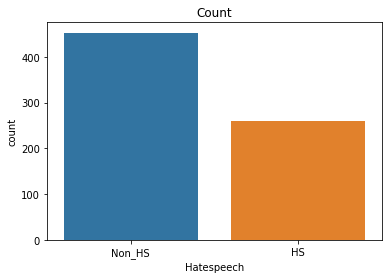

In [14]:
sns.countplot(df.Label)
plt.xlabel('Hatespeech')
plt.title('Count')

In [16]:
temp = df.groupby('Label').count()['Tweet'].reset_index().sort_values(by='Tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Label,Tweet
1,Non_HS,453
0,HS,260


In [19]:
from plotly import graph_objs as go
fig = go.Figure(go.Funnelarea(
    text =temp.Label,
    values = temp.Tweet,
    title = {"position": "top center", "text": "Funnel-Chart of Hatespeech Distribution"}
    ))
fig.show()

In [20]:
df['Label'] = df['Label'].map({
    "Non_HS" : 0,
    "HS" : 1
})
df.head()

,Label,Tweet
0,0,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,0,RT @baguscondromowo: Mereka terus melukai aksi...
2,0,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,0,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,0,RT @lisdaulay28: Waspada KTP palsu.....kawal P...


Oversampling

In [21]:
# Class count
count_class_0, count_class_1 = df.Label.value_counts()

# Divide by class
df_class_0 = df[df['Label'] == 0]
df_class_1 = df[df['Label'] == 1]

Random over-sampling:
1    453
0    453
Name: Label, dtype: int64


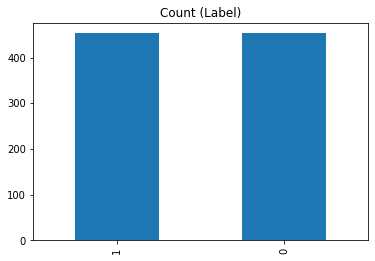

In [23]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Label.value_counts())

df_test_over.Label.value_counts().plot(kind='bar', title='Count (Label)');

In [25]:
df_test_over

,Label,Tweet
0,0,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,0,RT @baguscondromowo: Mereka terus melukai aksi...
2,0,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,0,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,0,RT @lisdaulay28: Waspada KTP palsu.....kawal P...
...,...,...
590,1,"ahmad dhani itu borok, sampah, babi, anjing. S..."
701,1,Maksudnya terbukti KORUPSI dan PENISTAAN agama...
621,1,RT @korban_gusur: @RakyatBiasa1945 Ada CEBONG ...
591,1,Lah emang sdh jelas2 si ahok terdakwa penista ...


#Praproses

In [12]:
PATH_BASE = 'drive/My Drive/NLP/'
DATASET_FOLDER = 'data'

singkatan_path = os.path.join(PATH_BASE, DATASET_FOLDER, 'singkatan.csv')
df_singkatan = pd.read_csv(singkatan_path, header=None)
df_singkatan.columns = ['singkatan', 'kata baku', 'example sms text']
df_singkatan['kata baku'] = df_singkatan['kata baku'].replace('.', np.nan)

df_singkatan.dropna(inplace=True)
dict_singkatan = dict(zip(df_singkatan.singkatan, df_singkatan['kata baku']))
dict_singkatan['jl'] = "jalan"
dict_singkatan['dr'] = "dari"

slang_path = os.path.join(PATH_BASE, DATASET_FOLDER, 'slang.json')
with open(slang_path) as json_slang:
  dict_slang = json.load(json_slang)

dict_slang['alig'] = "gila"
dict_clean = {**dict_singkatan, **dict_slang}
print(dict_clean)

stopwords_path = os.path.join(PATH_BASE, DATASET_FOLDER, 'stopword.xlsx')
df_stopwords = pd.read_excel(stopwords_path, header=None)
list_stopwords = list(df_stopwords[0])
print(list_stopwords)

{'knp': 'kenapa', 'udh': 'udah', 'gmn': 'bagaimana', 'kluar': 'keluar', 'tnya': 'tanya', 'skrng': 'sekarang ', 'trims': 'terima kasih', 'krna': 'karena', 'promil': 'promil', 'infonya': 'infonnya', 'tespek': 'test pack', 'kmrn': 'kemarin', 'mksh': 'terima kasih', 'stlh': 'setelah', 'mnggu': 'minggu', 'knpa': 'kenapa', 'gmna': 'bagaimana', 'hmil': 'hamil', 'smpe': 'sampai', 'mggu': 'minggu', 'mhon': 'mohon', 'sprti': 'seperti', 'kmren': 'kemaren', 'khamilan': 'kehamilan ', 'pdhl': 'padahal ', 'tny': 'tanya', 'sdah': 'sudah ', 'hrus': 'harus', 'sblm': 'sebelum', 'trmksh': 'terima kasih', 'mnum': 'minum ', 'dtg': 'datang', 'knapa': 'kenapa', 'priksa': 'periksa', 'jdi': 'jadi', 'slma': 'selama', 'sblmnya': 'sebelumnya', 'skali': 'sekali', 'bumil': 'ibu hamil', 'trakhir': 'terakhir', 'obt': 'obat ', 'prnh': 'pernah', 'kmrin': 'kemaren', 'bgmn': 'bagaimana', 'tespack': 'test pack', 'slmt': 'selamat ', 'brapa': 'berapa', 'kmudian': 'kemudian', 'pnya': 'punya ', 'pdhal': 'padahal ', 'kedokter':

In [13]:
def text_cleansing(text):
  pat1 = r'@[A-Za-z0-9]+'
  pat2 = r'https?://[A-Za-z0-9./]+'
  pat3 = r'RT '
  combined_pat = r'|'.join((pat1, pat2, pat3))
  clean_text = re.sub(combined_pat, '', text)
  clean_text = re.sub("[^a-zA-Z]", " ", clean_text)
  clean_text = " ".join(clean_text.split())
  result = clean_text.lower()
  return result

def preprocessing_slang_singkatan(text, dict_clean=dict_clean):
  regex = r"\b(?:"+"|".join(re.escape(word) for word in dict_clean) + r")\b"
  reobj = re.compile(regex, re.I)
  
  return reobj.sub(lambda x:dict_clean[x.group(0)], text)

def remove_stopwords(x, list_stopwords=list_stopwords):
  return " ".join([w for w in x.split() if not w in list_stopwords])

def clean_all(x, dict_clean=dict_clean, list_stopwords=list_stopwords):
  x = text_cleansing(x)
  x = preprocessing_slang_singkatan(x, dict_clean=dict_clean)
  x = remove_stopwords(x, list_stopwords=list_stopwords)
  return x


In [26]:
tqdm.pandas()
df.Tweet = df.Tweet.progress_apply(lambda x: clean_all(x, dict_clean=dict_clean,
                                                      list_stopwords=list_stopwords))

100%|██████████| 713/713 [00:03<00:00, 210.59it/s]


In [37]:
pd.set_option('display.max_colwidth', -1)
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,Label,Tweet
0,0,fadli zon mendagri menonaktifkan ahok gubernur dki https t co kh virwpdo
1,0,melukai aksi rangka memenjarakan ahok ahok gagal pemilihan kepala daerah
2,0,sylvi gurbernur kekerasan perempuan buktinya foto bareng debatfinalpilkadajkt
3,0,ahmad dhani puas debat pemilihan kepala daerah masalah jalan di bekasi terungkap https t co m hoppluid
4,0,waspada ktp palsu kawal pemilihan kepala daerah https t co oooerqv sm
...,...,...
708,1,muka si babi ahok tuh yang serbet lantai btp
709,1,bang hancurkan merka bang musnahkan china babi dibumi pertiwi indonesia berkedok reklamasi ahok
710,1,sapa yang bilang ahok anti korupsi grombolannya bicara gtu wajar ahok mafia koruptor sang penista agama yang dilindungi istana pki
711,1,ngimpi sentilin biji babi ahok pcetar pcetar langsung kejang die ngadu jkw jkw makanye sunat bicara almaidah


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   713 non-null    int64 
 1   Tweet   713 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.3+ KB


#Split Data

In [28]:
df_train, df_test = train_test_split(df, test_size=0.2)

#Feature Extraction

In [30]:
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(df['Tweet'])
Train_X_Tfidf = Tfidf_vect.transform(df_train['Tweet'])
Test_X_Tfidf = Tfidf_vect.transform(df_test['Tweet'])
y_train = df_train['Label'].to_numpy()
y_test = df_test['Label'].to_numpy()

#Classification

In [31]:
def klasifikasi(df):
  classifier = SVC(kernel=df, random_state=1)
  classifier.fit(Train_X_Tfidf, y_train)

  y_pred = classifier.predict(Test_X_Tfidf)
  print('confussion matrix = ')
  cm = confusion_matrix(y_test, y_pred)
  print(classification_report(y_test, y_pred))
  print(cm)
  print('result = ')
  print('akurasi  =',accuracy_score(y_test, y_pred)*100,'%')

  print('presisi  =',precision_score(y_test, y_pred, average='macro')*100,'%')

  print('recall   =',recall_score(y_test, y_pred, average='macro')*100,'%')

  print('f1 score =',f1_score(y_test, y_pred, average='macro')*100,'%')

In [32]:
klasifikasi('poly')

confussion matrix = 
              precision    recall  f1-score   support

           0       0.61      1.00      0.75        86
           1       1.00      0.02      0.03        57

    accuracy                           0.61       143
   macro avg       0.80      0.51      0.39       143
weighted avg       0.76      0.61      0.47       143

[[86  0]
 [56  1]]
result = 
akurasi  = 60.83916083916085 %
presisi  = 80.28169014084507 %
recall   = 50.877192982456144 %
f1 score = 39.44343617664851 %


In [33]:
klasifikasi('sigmoid')

confussion matrix = 
              precision    recall  f1-score   support

           0       0.80      0.97      0.87        86
           1       0.92      0.63      0.75        57

    accuracy                           0.83       143
   macro avg       0.86      0.80      0.81       143
weighted avg       0.85      0.83      0.82       143

[[83  3]
 [21 36]]
result = 
akurasi  = 83.21678321678321 %
presisi  = 86.0576923076923 %
recall   = 79.83476132190943 %
f1 score = 81.18421052631578 %


In [34]:
klasifikasi('rbf')

confussion matrix = 
              precision    recall  f1-score   support

           0       0.77      0.99      0.87        86
           1       0.97      0.56      0.71        57

    accuracy                           0.82       143
   macro avg       0.87      0.77      0.79       143
weighted avg       0.85      0.82      0.81       143

[[85  1]
 [25 32]]
result = 
akurasi  = 81.81818181818183 %
presisi  = 87.12121212121212 %
recall   = 77.48878008975927 %
f1 score = 78.92290249433105 %


Best Result

In [35]:
klasifikasi('linear')

confussion matrix = 
              precision    recall  f1-score   support

           0       0.80      0.97      0.87        86
           1       0.92      0.63      0.75        57

    accuracy                           0.83       143
   macro avg       0.86      0.80      0.81       143
weighted avg       0.85      0.83      0.82       143

[[83  3]
 [21 36]]
result = 
akurasi  = 83.21678321678321 %
presisi  = 86.0576923076923 %
recall   = 79.83476132190943 %
f1 score = 81.18421052631578 %


#Evaluation

In [38]:
classifier = SVC(kernel="linear", random_state=1)
classifier.fit(Train_X_Tfidf, y_train)
y_pred = classifier.predict(Test_X_Tfidf)

In [39]:
df_pred = df_test.copy()
df_pred['prediksi'] = y_pred
df_pred['true_prediction'] = np.where(df_pred['prediksi'] == df_test['Label'], True, False)
df_pred.to_excel("prediksi_hatespeech.xlsx")  

In [40]:
pd.set_option('display.max_colwidth', -1)
df_diff = df_pred.loc[df_pred['true_prediction'] == True]
display(df_diff)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,Label,Tweet,prediksi,true_prediction
412,0,ahok mendoakan ahok pagi jam kecewa hasil pemilihan kepala daerah,0,True
336,0,yang terbaik di ajang debat terbuka,0,True
162,0,kahfi komplit banget yaaaa heran nya yang percaya idolain,0,True
572,1,gusur iya trump penista agama anti islam emang hubungannya anis apa,1,True
111,0,presiden kapolri ok oce tuh apa debatfinalpilkadajkt,0,True
...,...,...,...,...
25,0,iya deh dripada isu bohong,0,True
675,1,deh btp hina islam manusia hina dibandingkan agama yang mulia apa iklanahokjahat,1,True
352,0,i love you ahok berdoa semoga tuhan memberkati salam jari pa ahok i love you,0,True
215,0,penganut agama hak yang ahok matanajwadebatjakarta,0,True


In [41]:
df_diff2 = df_pred.loc[df_pred['true_prediction'] == False]
display(df_diff2)

,Label,Tweet,prediksi,true_prediction
536,1,uang taipan tuh nanti dibayar ratusan penggusuran biadab ahok,0,False
468,1,ahok menang pemilihan kepala daerah bikin video sex bareng anaknya tan https t co msmthwwlk,0,False
512,1,norak banget iklan mantan mendikbud gak respech tenun kebangsaan yang maksud https t co ux heykblg,0,False
48,0,debatfinalpilkadajkt telak banget anjing tertawa,1,False
531,1,tionghoa kaya putus sekolah kebanyakan dugem,0,False
514,1,dari bu sylvi gak mutu debatfinalpilkadajkt,0,False
10,0,gak jokowi ahok kalem melengkapi,1,False
628,1,matanajwadebatjakarta anies sadis topengmu terbuka lebar malam biar warga dki yang menilai apa yang pengecut,0,False
627,1,janganmaudibohongiahok ahok sumber kekacauan politik ramaikan aski fight,0,False
533,1,ahoker yang takut matinya gg disholatin tenang ada abu janda ust gadungan yang sholatin ahoker jokower,0,False


#Analyze

#### Common Word

In [42]:
df_result = df_pred.copy()

In [43]:
df_result['temp_list'] = df_result['Tweet'].apply(lambda x:str(x).split())

In [44]:
HS_sent = df_result[df_result['Label']== 1]
NON_HS_sent = df_result[df_result['Label']== 0]

In [46]:
from collections import Counter

#MosT common hatespeech words
top = Counter([item for sublist in HS_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,ahok,29
1,yang,25
2,agama,19
3,penista,16
4,si,12
5,babi,11
6,islam,10
7,tuh,6
8,apa,6
9,cina,6


In [47]:
#MosT common non HS words
top = Counter([item for sublist in NON_HS_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,ahok,26
2,di,16
3,debatfinalpilkadajkt,16
4,pemilihan,11
5,kepala,11
6,daerah,11
7,debat,11
8,jakarta,11
9,matanajwadebatjakarta,10
10,iya,9


#### Unique Word

In [48]:
raw_text = [word for word_list in df_result['temp_list'] for word in word_list]

In [50]:
def words_unique(Label,numwords,raw_words):

    allother = []
    for item in df_result[df_result.Label != Label]['temp_list']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in df_result[df_result.Label == Label]['temp_list']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

In [51]:
Unique_Positive= words_unique(1, 20, raw_text)
print("The top 20 unique words in Hatespeech Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Hatespeech Tweets are:


,words,count
0,si,12
1,babi,11
2,islam,10
3,cina,6
4,kafir,6
5,bodoh,4
6,terdakwa,4
7,kristen,3
8,banjir,3
9,ga,3


In [54]:
Unique_Negative= words_unique(0, 10, raw_text)
print("The top 10 unique words in Non Hatespeech Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Non Hatespeech Tweets are:


,words,count
0,paslon,8
1,terbaik,4
2,rakyat,4
3,kerja,4
4,pagi,3
5,jujur,3
6,berdoa,3
7,selamat,3
8,hidup,3
9,memiliki,3
